# Regression Trees and Model Optimization - Lab

## Introduction

In this lab, we'll see how to apply regression analysis using CART trees while making use of some hyperparameter tuning to improve our model. 

## Objectives

In this lab you will: 

- Perform the full process of cleaning data, tuning hyperparameters, creating visualizations, and evaluating decision tree models 
- Determine the optimal hyperparameters for a decision tree model and evaluate the performance of decision tree models

## Ames Housing dataset 

The dataset is available in the file `'ames.csv'`. 

- Import the dataset and examine its dimensions: 

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Load the Ames housing dataset 
data = pd.read_csv('ames.csv')

# Print the dimensions of data
print(data.shape)

(1460, 81)


In [2]:
# Show the first 5 rows
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# Check out the info for the dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## Identify features and target data 

In this lab, we will use using 3 predictive continuous features:

#### Features

- `LotArea`: Lot size in square feet
- `1stFlrSF`: Size of first floor in square feet
- `GrLivArea`: Above grade (ground) living area square feet

#### Target

- `SalePrice`', the sale price of the home, in dollars

- Create DataFrames for the features and the target variable as shown above 
- Inspect the contents of both the features and the target variable

In [5]:
# Features and target data
target = data['SalePrice']
features = data[['LotArea', '1stFlrSF', 'GrLivArea']]

In [6]:
features.head()

,LotArea,1stFlrSF,GrLivArea
0,8450,856,1710
1,9600,1262,1262
2,11250,920,1786
3,9550,961,1717
4,14260,1145,2198


In [7]:
target

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

## Inspect correlations 

- Use scatter plots to show the correlation between the chosen features and the target variable
- Comment on each scatter plot 

In [8]:
features.columns

Index(['LotArea', '1stFlrSF', 'GrLivArea'], dtype='object')

<ipython-input-16-65e4f9bcaaf8>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


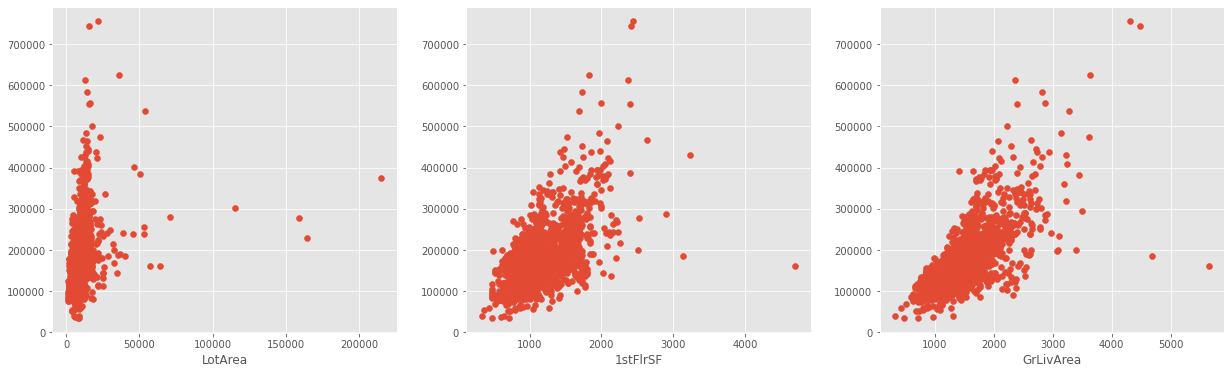

In [16]:
# Your code here 
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(21,6))

for i,col in enumerate(features.columns):
    ax = axes[i]
    
    ax.scatter(features[col], target)
    ax.set_xlabel(col)
    
fig.show();

The relationships between `LotArea`, `1stFLrSF`, and `GrLivArea` vs. target variable `SalePrice` appear to be relatively linear.

## Create evaluation metrics

- Import `r2_score` and `mean_squared_error` from `sklearn.metrics` 
- Create a function `performance(true, predicted)` to calculate and return both the R-squared score and Root Mean Squared Error (RMSE) for two equal-sized arrays for the given true and predicted values 
    - Depending on your version of sklearn, in order to get the RMSE score you will need to either set `squared=False` or you will need to take the square root of the output of the `mean_squared_error` function - check out [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) or this helpful and related [StackOverflow post](https://stackoverflow.com/questions/17197492/is-there-a-library-function-for-root-mean-square-error-rmse-in-python)
    - The benefit of calculating RMSE instead of the Mean Squared Error (MSE) is that RMSE is in the same units at the target - here, this means that RMSE will be in dollars, calculating how far off in dollars our predictions are away from the actual prices for homes, on average

In [17]:
# Import metrics
from sklearn.metrics import r2_score, mean_squared_error

# Define the function
def performance(y_true, y_predict):
    """ 
    Calculates and returns the two performance scores between 
    true and predicted values - first R-Squared, then RMSE
    """

    # Calculate the r2 score between 'y_true' and 'y_predict'
    r2 = r2_score(y_true, y_predict)
    # Calculate the root mean squared error between 'y_true' and 'y_predict'
    rmse = np.sqrt(mean_squared_error(y_true, y_predict))
    # Return the score
    return [r2, rmse]


# Test the function
score = performance([3, -0.5, 2, 7, 4.2], [2.5, 0.0, 2.1, 7.8, 5.3])
score

# [0.9228556485355649, 0.6870225614927066]

[0.9228556485355649, 0.6870225614927066]

## Split the data into training and test sets

- Split `features` and `target` datasets into training/test data (80/20) 
- For reproducibility, use `random_state=42`

In [18]:
from sklearn.model_selection import train_test_split 

# Split the data into training and test subsets
x_train, x_test, y_train, y_test = train_test_split(features, target, 
                                                    test_size=0.2, random_state=42)

## Grow a vanilla regression tree

- Import the `DecisionTreeRegressor` class
- Run a baseline model for later comparison using the datasets created above
- Generate predictions for test dataset and calculate the performance measures using the function created above 
- Use `random_state=45` for tree instance
- Record your observations

In [20]:
# Import DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

# Instantiate DecisionTreeRegressor 
# Set random_state=45
regressor = DecisionTreeRegressor(random_state=45)

# Fit the model to training data
regressor.fit(x_train, y_train)

# Make predictions on the test data
y_pred = regressor.predict(x_test)

# Calculate performance using the performance() function 
score = performance(y_test, y_pred)
score

# [0.5961521990414137, 55656.48543887347] - R2, RMSE

[0.5961521990414137, 55656.48543887347]

## Hyperparameter tuning (I)

- Find the best tree depth using depth range: 1-30
- Run the regressor repeatedly in a `for` loop for each depth value  
- Use `random_state=45` for reproducibility
- Calculate RMSE and r-squared for each run 
- Plot both performance measures for all runs 
- Comment on the output 

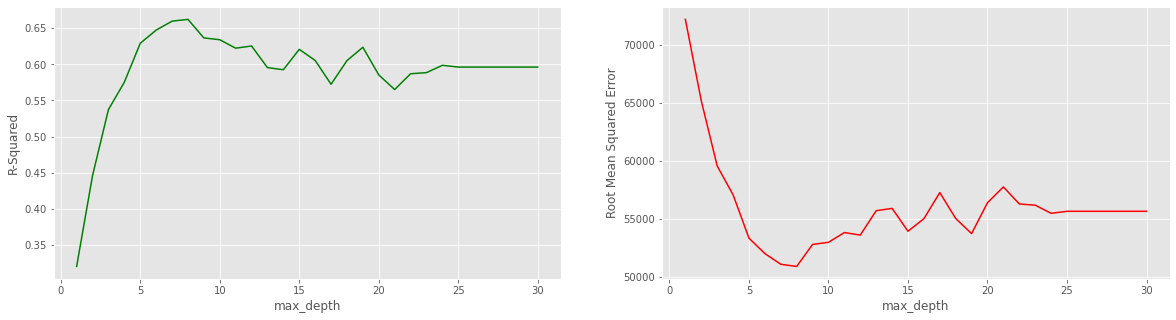

In [28]:
# Your code here 
depth_range = np.arange(1,31)
r2_scores = []
rmse_scores = []

for val in depth_range:
    regressor = DecisionTreeRegressor(random_state=45, max_depth=val)
    regressor.fit(x_train, y_train)
    y_pred = regressor.predict(x_test)
    scores = performance(y_test, y_pred)
    
    r2_scores.append(scores[0])
    rmse_scores.append(scores[1])
    
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
ax1.plot(depth_range, r2_scores, color='green')
ax1.set_xlabel('max_depth')
ax1.set_ylabel('R-Squared')

ax2.plot(depth_range, rmse_scores, color='red')
ax2.set_xlabel('max_depth')
ax2.set_ylabel('Root Mean Squared Error')
plt.show();

In [29]:
print(depth_range[np.argmax(r2_scores)])
print(depth_range[np.argmin(rmse_scores)])

8
8


In [ ]:
# The most optimal max_depth within the [1,30] range seems to be 8 so far

## Hyperparameter tuning (II)

- Repeat the above process for `min_samples_split` 
- Use a range of values from 2-10 for this hyperparameter 
- Use `random_state=45` for reproducibility
- Visualize the output and comment on results as above 

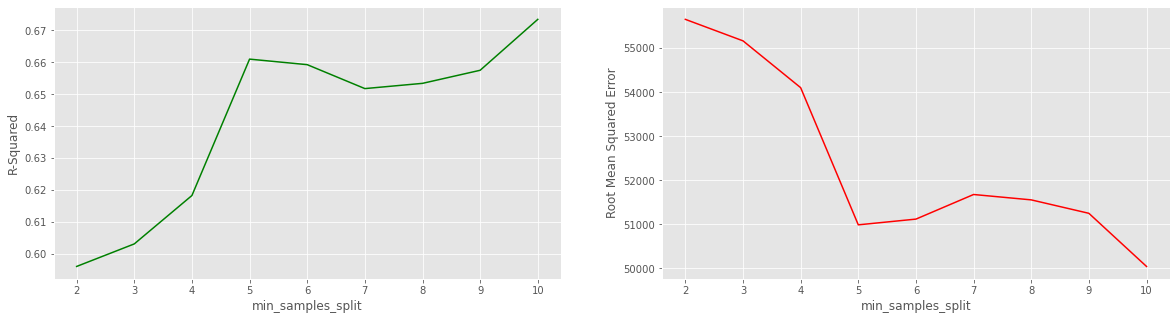

In [33]:
# Your code here 

min_samples_range = np.arange(2,11)
r2_scores = []
rmse_scores = []

for val in min_samples_range:
    regressor = DecisionTreeRegressor(random_state=45, min_samples_split=val)
    regressor.fit(x_train, y_train)
    y_pred = regressor.predict(x_test)
    scores = performance(y_test, y_pred)
    
    r2_scores.append(scores[0])
    rmse_scores.append(scores[1])
    
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
ax1.plot(min_samples_range, r2_scores, color='green')
ax1.set_xlabel('min_samples_split')
ax1.set_ylabel('R-Squared')

ax2.plot(min_samples_range, rmse_scores, color='red')
ax2.set_xlabel('min_samples_split')
ax2.set_ylabel('Root Mean Squared Error')
plt.show();

In [34]:
print(min_samples_range[np.argmax(r2_scores)])
print(min_samples_range[np.argmin(rmse_scores)])

10
10


In [ ]:
# The most optimal min_samples_split within the [2,10] range seems to be 10 so far

# Run the *optimized* model 

- Use the best values for `max_depth` and `min_samples_split` found in previous runs and run an optimized model with these values 
- Calculate the performance and comment on the output 

In [35]:
# Your code here 
optimized_model = DecisionTreeRegressor(random_state=45, max_depth=8, min_samples_split=10)
optimized_model.fit(x_train, y_train)
y_pred = optimized_model.predict(x_test)

performance(y_test, y_pred)

[0.6797912086364211, 49559.11504625333]

## Level up (Optional)

- How about bringing in some more features from the original dataset which may be good predictors?
- Also, try tuning more hyperparameters like `max_features` to find a more optimal version of the model 

In [47]:
# drop columns with high number of missing values or irrelevant
df = data.drop(['Id', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], axis=1)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

In [74]:
# There're no duplicated rows
any(df.duplicated())

False

In [ ]:
# Separate continuous & categorical features
cat = [col for col in df.columns if df[col].dtypes=='O']
cont = list(set(df.columns) - set(cat))

In [75]:
# convert categorical to dummies
df_cat = pd.get_dummies(df[cat], drop_first=True)

In [80]:
any(df_cat.isna().sum() > 0)

False

In [81]:
df_master = pd.concat([df_cat, df[cont]], axis=1)

In [83]:
X = df_master.drop('SalePrice', axis=1)
y = df_master.SalePrice

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=45, test_size=0.2)

In [88]:
df_master.isna().sum()[df_master.isna().sum() > 0]

MasVnrArea       8
LotFrontage    259
GarageYrBlt     81
dtype: int64

In [89]:
# Use simple imputer to fill in missing values with the most_frequent/median
from sklearn.impute import SimpleImputer

si = SimpleImputer(strategy='most_frequent')
X_train = si.fit_transform(X_train)
X_test = si.transform(X_test)

In [99]:
# create a range of feature counts
features = range(1, len(df.columns))

r2_scores = []
rmse_scores = []

for val in features:
    regressor = DecisionTreeRegressor(random_state=45, 
                                      max_features=val)
    
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    scores = performance(y_test, y_pred)
    r2_scores.append(scores[0])
    rmse_scores.append(scores[1])

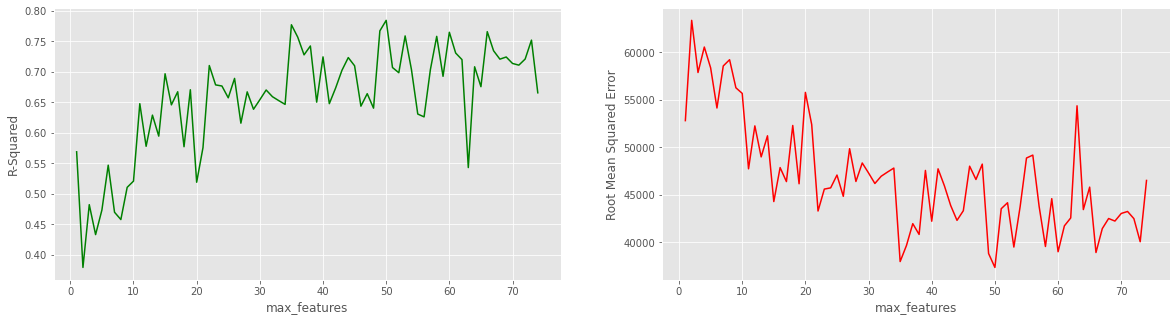

In [100]:
# Plot R Squared & RMSE scores    
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
ax1.plot(features, r2_scores, color='green')
ax1.set_xlabel('max_features')
ax1.set_ylabel('R-Squared')

ax2.plot(features, rmse_scores, color='red')
ax2.set_xlabel('max_features')
ax2.set_ylabel('Root Mean Squared Error')
plt.show();

In [101]:
print(features[np.argmax(r2_scores)])
print(features[np.argmin(rmse_scores)])

50
50


In [103]:
# Fit a model using optimized parameters:
optimized_model = DecisionTreeRegressor(random_state=45, 
                                        max_depth=8, 
                                        min_samples_split=10,
                                        max_features=50)
optimized_model.fit(X_train, y_train)
y_pred = optimized_model.predict(X_test)

performance(y_test, y_pred)

[0.7356561824234573, 41356.729111852546]

## Summary 

In this lab, we looked at applying a decision-tree-based regression analysis on the Ames Housing dataset. We saw how to train various models to find the optimal values for hyperparameters. 